# Hypothesis

Use tesseract-ocr which has trained data for 7 segment displays.

## Approach

1. Image Threshold
2. Edge detect
3. Detect contours 
4. Filter contours 
5. Find bounding box of 7 segment display
6. Pass image bounding box to tesseract
7. Test match result


## Dependencies

__Install following (if not already available in docker container)__

```
apt-get install ffmpeg libsm6 libxext6  -y
```

__Install python wrapper__

```
pip install opencv-contrib-python
```

__Install OCR package__

```
apt install tesseract-ocr
pip install pytesserat
```

__Install 7 segment trained data__

Derived from: git clone https://github.com/Shreeshrii/tessdata_ssd
```
cp trained_data/7seg.traineddata /usr/share/tesseract-ocr/4.00/tessdata
cp trained_data/ssd.traineddata /usr/share/tesseract-ocr/4.00/tessdata
cp trained_data/ssd_int.traineddata /usr/share/tesseract-ocr/4.00/tessdata
```
Note: 7seg seems to be best for LCD display.


In [1]:
from ipywidgets import interact
from utils import utils
import cv2
import numpy as np
import pandas as pd
import pytesseract
import math
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks
import pylab # this allows you to control figure size 
pylab.rcParams['figure.figsize'] = (8.0, 6.0) # this controls figure size in the notebook

img_path = './images/LCD_heating_18.jpeg'
is_ESP32CAM_image = False
#img_path = './images/LCD_heating_15_02.jpg'
#img_path = './images/LCD_heating_15_01.jpg'
#img_path = './images/LCD_heating_esp32cam_14.png'


### Rotate Image

Rotate image if from ESP32 CAM

In [2]:
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
if (is_ESP32CAM_image):
    
    # grab the dimensions of the image and calculate the center of the image
    (h, w) = img.shape[:2]
    (cX, cY) = (w / 2, h / 2)

    # rotate image by 90 degrees around the center of the image
    M = cv2.getRotationMatrix2D((cX, cY), 90, 1.0)
    img = cv2.warpAffine(img, M, (w, h))
    plt.imshow(img, cmap = 'gray')


### Thresholding Approach

Work out the best thresholding approach to maximise contour detection and Hough transform line detection. 

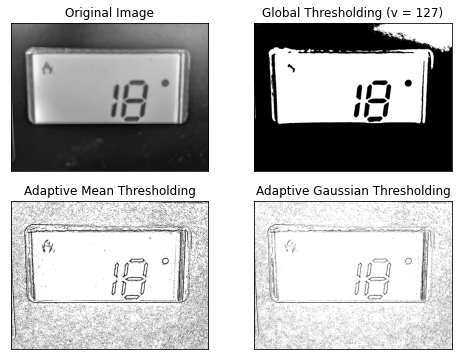

In [3]:
#img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_blur = cv2.medianBlur(img,5)

ret,th1 = cv2.threshold(img_blur,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img_blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img_blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img_blur, th1, th2, th3]
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

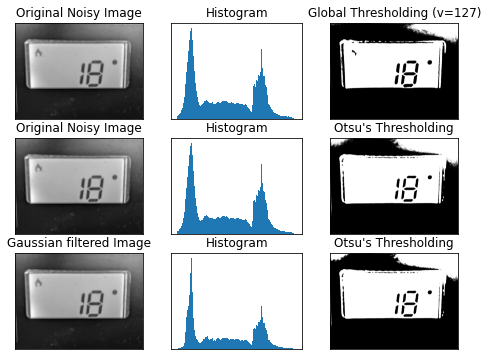

In [4]:
# global thresholding
ret1, th1 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# Otsu's thresholding
ret2, th2 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img, (5,5), 0)
ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]

titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

### Edge Detection

Canny edge detector.

In [5]:
def canny(Value):
    edges = cv2.Canny(th3, Value, 200, 255)
    plt.imshow(edges, cmap = 'gray')
    plt.title('Canny Edge Detection')
    
interact(canny,Value=(1,255,2))

edges = cv2.Canny(th3, 127, 200, 255)

interactive(children=(IntSlider(value=127, description='Value', max=255, min=1, step=2), Output()), _dom_class…

### Find and filter contours

Options:

 - Use Hu moments of contours to select and filter 7 segment elements. Hu moments are invariant to scale, translation and rotation. Use Hu moments to cluster.
 - Basic area calculation and clustering

Total points: 74
[[3.33771120e+00 7.40055556e+02 1.31757514e+02 3.34316224e+01
  6.26973438e+04 1.57466777e+06]
 [3.76120012e+00 6.55000000e+01 7.50718201e+03 2.98145315e+03
  1.66078448e+05 1.65405015e+10]
 [3.49650756e+00 3.65000000e+01 3.69200626e+03 1.03122748e+03
  1.02765000e+06 1.36771953e+09]]


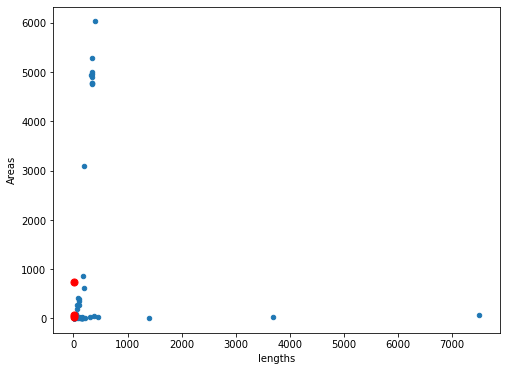

In [6]:
# Get contours
#  RETR_TREE
#  RETR_EXTERNAL - best
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

log_indexs = []
areas = []
lengths = []
moments_m0 = []
moments_m1 = []
moments_m2 = []

i = 0
for cnt in contours:
    area = cv2.contourArea(cnt)
    arclength = cv2.arcLength(cnt,False)
    if (area>10):
        areas.append(area)
        lengths.append(arclength)
        M = cv2.moments(cnt)
        huM = cv2.HuMoments(M).flatten()
        moments_m0.append(huM[0])
        moments_m1.append(huM[1])
        moments_m2.append(huM[2])
        log_indexs.append(math.log(i+1))
        i += 1

dataset = list(zip(log_indexs, areas,lengths,moments_m0,moments_m1,moments_m2))
df = pd.DataFrame(data = dataset, columns=['Log_indexes', 'Areas', 'lengths', 'M0', 'M1', 'M2'])
df.plot.scatter(x='lengths', y='Areas')
print("Total points:", i)

kmeans = KMeans(n_clusters=3).fit(df)
centroids = kmeans.cluster_centers_
#plt.scatter(df['Log_indexes'], df['Areas'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
print(centroids)

,m1,m2,m3,m4,m5,m6,m7
0,0.313325,0.071562,0.000017,0.000006,0.0,0.000002,-0.0
1,0.318208,0.073588,0.000482,0.000052,-0.0,-0.000007,-0.0
2,0.303151,0.064793,0.000237,0.000081,0.0,0.000014,-0.0
3,0.304812,0.065887,0.000316,0.000105,0.0,0.000016,-0.0
4,0.380718,0.118919,0.000043,0.00001,0.0,0.000001,0.0
5,0.314912,0.072204,0.000185,0.000023,-0.0,-0.000003,-0.0
6,0.31295,0.070556,0.00054,0.000051,-0.0,-0.000013,-0.0
7,0.319868,0.075067,0.000208,0.000021,-0.0,-0.000003,-0.0
8,0.341739,0.089982,0.000084,0.000049,0.0,0.000014,0.0
9,0.160161,0.000271,0.000001,0.0,0.0,0.0,0.0


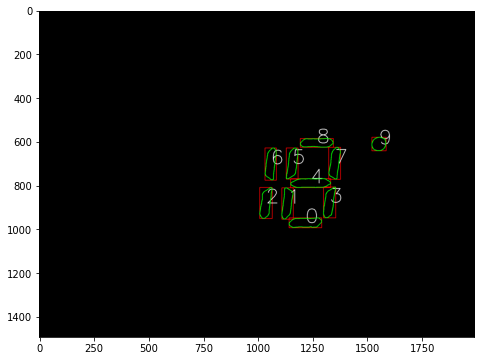

In [7]:
# Find contours
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Create blank image of same size as source image
d = img.shape
blank_image = np.zeros((d[0], d[1], 3), np.uint8)

# Get contours
#RETR_TREE
#RETR_EXTERNAL - best
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Contours that match a 7 segment element
filtered_contours = []

# Dataframe of Hu moments
df = pd.DataFrame(columns=["m1", "m2", "m3", "m4", "m5", "m6", "m7"])

i = 0
# Eliminate non seven segment contours
for cnt in contours:
    approx = cv2.contourArea(cnt)
    if (approx > 1000):    # FIXME: Use Hu moments to filter rather than contourArea?
        perimeter = cv2.arcLength(cnt,True)
        #print (perimeter)
        M = cv2.moments(cnt)
        huM = cv2.HuMoments(M).flatten()

        x,y,w,h = cv2.boundingRect(cnt)
        cv2.rectangle(blank_image,(x,y),(x+w,y+h),(255,0,0),2)
        cv2.putText(blank_image, str(i), (x+int(w/2),y+int(h/2)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 255, 255), 2, cv2.LINE_AA)
        i += 1
        entry = pd.DataFrame.from_dict({
             "m1": [ huM[0] ],
             "m2": [ huM[1] ],
             "m3": [ huM[2] ],
             "m4": [ huM[3] ],
             "m5": [ huM[4] ],
             "m6": [ huM[5] ],
             "m7": [ huM[6] ]
        })

        df = pd.concat([df, entry], ignore_index=True)
        filtered_contours.append(cnt)

cv2.drawContours(image=blank_image, contours=filtered_contours, contourIdx=-1, 
                 color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

plt.imshow(blank_image)
df

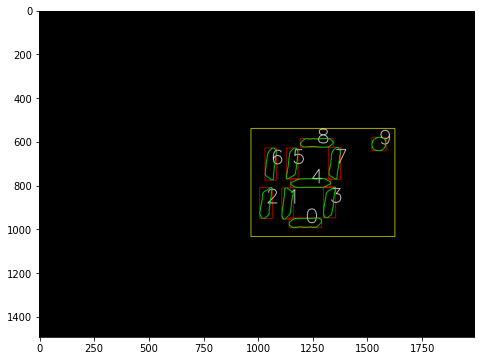

In [8]:
# Find bounding box for all 7 segment contours
x1, y1, x2, y2 = utils.boundingRectForContours(filtered_contours)

cv2.rectangle(blank_image,(x1,y1),(x2,y2),(255,255,0),2)
plt.imshow(blank_image)

(1492, 1990)
967 540 1624 1033


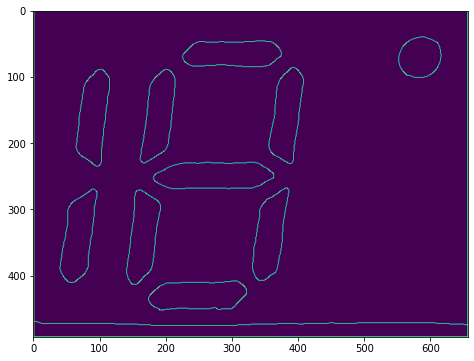

In [9]:
# Segment image
img = edges #cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
print (img.shape)

print (x1, y1, x2, y2)
h = y2 - y1
w = x2 - x1
cropped_image = img[y1:y1+h, x1:x1+w]

cv2.rectangle(img,(x1,y1),(x2,y2),(255,255,0),2)
plt.imshow(img)
plt.imshow(cropped_image)

## OCR Segmented Image

Use Tesseract to OCR the segmented image. The trained data set used is specific for 7 segments.

In [10]:
# OCR
d = pytesseract.image_to_string(cropped_image, config="-l 7seg --psm 8") # best
#d = pytesseract.image_to_string(thr, config="-l ssd_int --psm 8")
#d = pytesseract.image_to_string(thr, config="-l 7seg --psm 8")
print(d)

10 °



# Shape Matching Methods

𝐴 denotes object1, 𝐵 denotes object2

$m_{i}^{A} = sign(h_{i}^{A}) . log(h_{i}^{A})$

$m_{i}^{B} = sign(h_{i}^{B}) . log(h_{i}^{B})$

and $h_{i}^{A}$, $h_{i}^{B}$ are the Hu moments of 𝐴 and 𝐵, respectively.

$ I_{2}(A, B) = \sum \limits _{i=1..7} \lvert m_{i}^{A} - m_{i}^{B} \vert$


In [11]:
# reference segments for shape matching
all_seg_hu = [ (0.313325, 0.071562, 0.000017, 0.000006, 0.0, 0.000002, -0.0),
            (0.318208, 0.073588, 0.000482, 0.000052, -0.0, -0.000007, -0.0),
            (0.304812, 0.065887, 0.000316, 0.000105, 0.0, 0.000016, -0.0),
            (0.380718, 0.118919, 0.000043, 0.00001, 0.0, 0.000001, 0.0),
            (0.314912, 0.072204, 0.000185, 0.000023, -0.0, -0.000003, -0.0),
            (0.319868, 0.075067, 0.000208, 0.000021, -0.0, -0.000003, -0.0),
            (0.341739, 0.089982, 0.000084, 0.000049, 0.0, 0.000014, 0.0)]

df = pd.DataFrame(all_seg_hu, 
                  columns=['m1','m2','m3','m4','m5','m6','m7'], 
                  index=['base','base_l','base_r','mid','top_l','top_r','top'])
df


,m1,m2,m3,m4,m5,m6,m7
base,0.313325,0.071562,0.000017,0.000006,0.0,0.000002,-0.0
base_l,0.318208,0.073588,0.000482,0.000052,-0.0,-0.000007,-0.0
base_r,0.304812,0.065887,0.000316,0.000105,0.0,0.000016,-0.0
mid,0.380718,0.118919,0.000043,0.000010,0.0,0.000001,0.0
top_l,0.314912,0.072204,0.000185,0.000023,-0.0,-0.000003,-0.0
top_r,0.319868,0.075067,0.000208,0.000021,-0.0,-0.000003,-0.0
top,0.341739,0.089982,0.000084,0.000049,0.0,0.000014,0.0


In [12]:
shouldmatch_hu_top_r = [ 0.31295, 0.070556, 0.00054, 0.000051, -0.0, -0.000013, -0.0]
shouldnotmatch_hu = [ 0.160161, 0.000271, 0.000001, 0.0, 0.0, 0.0, 0.0 ]

sign = lambda x: math.copysign(1, x)

sign_log = lambda x : sign(x) * math.log(x) if (x > 0) else 0

def hu_moment_compare(hA, hB):
    
    signfunc = np.vectorize(sign_log)    
    mA = signfunc(hA)
    mB = signfunc(hB)
    I2 = 0.0
    for i in range(0, 7):
        if (mB[i]!=0):
            I2 += abs(1/mA[i] - 1/mB[i])
        #print (I2)
    return I2

print ("test ", hu_moment_compare(all_seg_hu[5], all_seg_hu[5]))
for i in range(0, 7):
    print ("good ", i, hu_moment_compare(all_seg_hu[i], shouldmatch_hu_top_r))
for i in range(0, 7):
    print ("bad ", hu_moment_compare(all_seg_hu[i], shouldnotmatch_hu))
#print ("ref ", all_seg_hu[0])
#print ("good", shouldmatch_hu_top_l)

test  0.0
good  0 0.06277460405273587
good  1 0.020784020518805582
good  2 0.04539577132214
good  3 0.3149592784494996
good  4 0.03207778925576367
good  5 0.04883048691043651
good  6 0.1354044341608685
bad  0.5918211309943825
bad  0.6473917502788704
bad  0.593340731198684
bad  0.8645043777625424
bad  0.6221663865651068
bad  0.6413444842782874
bad  0.7130529182230808
